In [1]:
import pandas as pd
import matplotlib.pyplot as plt #Scatterplot

Ingesting the data

In [2]:
#The data is placed in an folder so we load the data through the folder with \
data1 = pd.read_excel("wine-data\winequality-red.xlsx", header=1)
data2 = pd.read_excel("wine-data\winequality-white.xlsx", header=1)

Aggregating the data together into one data file - but first we add a column named type

In [3]:
#Adding the type
data1["type"] = "red"
data2["type"] = "white"

# Merge/concatenate - the ignore_index resets the index numbers
wine = pd.concat([data1, data2], ignore_index=True)

In [4]:
#Shows a random sample, to show that the data is mixed
wine.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
4678,6.6,0.350,0.34,4.9,0.032,9.0,125.0,0.99253,3.32,0.81,12.0,5,white
2472,10.3,0.170,0.47,1.4,0.037,5.0,33.0,0.99390,2.89,0.28,9.6,3,white
1905,7.2,0.430,0.24,6.7,0.058,40.0,163.0,0.99500,3.20,0.41,9.9,5,white
2600,6.4,0.280,0.41,6.8,0.045,61.0,216.0,0.99520,3.09,0.46,9.4,5,white
2649,7.3,0.240,0.34,7.5,0.048,29.0,152.0,0.99620,3.10,0.54,9.0,5,white
5899,6.4,0.290,0.30,6.5,0.209,62.0,156.0,0.99478,3.10,0.40,9.4,5,white
6234,5.8,0.345,0.15,10.8,0.033,26.0,120.0,0.99494,3.25,0.49,10.0,6,white
1510,6.4,0.360,0.21,2.2,0.047,26.0,48.0,0.99661,3.47,0.77,9.7,6,red
3957,7.4,0.320,0.27,12.9,0.040,60.0,221.0,0.99831,3.05,0.66,9.4,5,white
2117,5.9,0.130,0.28,1.9,0.050,20.0,78.0,0.99180,3.43,0.64,10.8,6,white


Cleaning the data

In [5]:
#We use shape to show the size of the dataset, through the number of observations and how many variables there are
wine.shape

(6497, 13)

In [6]:
#Finding missing values (null) - It shows how many of the different variables has null values
print(wine.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64


Since there are no null values, we do not need to drop them

In [7]:
#Shows how many duplicated values there are. It compares all of the columns.
wine.duplicated().sum()

np.int64(1177)

We therefore have 1177 duplicates

In [8]:
#This shows the first five duplicates.
duplicates = wine[wine.duplicated()]
print(duplicates.head())

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4             7.4             0.700         0.00            1.90      0.076   
11            7.5             0.500         0.36            6.10      0.071   
27            7.9             0.430         0.21            1.60      0.106   
40            7.3             0.450         0.36            5.90      0.074   
65            7.2             0.725         0.05            4.65      0.086   

    free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4                  11.0                  34.0   0.9978  3.51       0.56   
11                 17.0                 102.0   0.9978  3.35       0.80   
27                 10.0                  37.0   0.9966  3.17       0.91   
40                 12.0                  87.0   0.9978  3.33       0.83   
65                  4.0                  11.0   0.9962  3.41       0.39   

    alcohol  quality type  
4       9.4        5  red  
11     10.5       

In [9]:
#Dropping the 1177 duplicates and resetting the index
wine.drop_duplicates(inplace=True, ignore_index=True)

Checking for damaged values

In [10]:
#Negative values - 
(wine.drop(columns="type") < 0).sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
#pH value 7 or bigger for wine, as wine is acid and 7 is neutral - 
wine[(wine['pH']>7)].sum()

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                   0
type                      0
dtype: object

The outliers for the "accepted" wine values

In [12]:
def check_min_max(list, expected_range):
    report = []
    for col, (min_val, max_val) in expected_range.items():
        count = ((list[col] < min_val) | (list[col] > max_val)).sum()
        report.append({"column": col, "outliers": count})

    report_df = pd.DataFrame(report)
    print(report_df)

In [13]:
#Our expected ranges for red wine
expected_ranges_red = {
    "fixed acidity": (4.6, 15.9),
    "volatile acidity": (0.12, 1.58),
    "citric acid": (0.0, 1.0),
    "residual sugar": (0.9, 15.5),
    "chlorides": (0.012, 0.611),
    "free sulfur dioxide": (1, 72),
    "total sulfur dioxide": (6, 289),
    "density": (0.99007, 1.00369),
    "pH": (2.74, 4.01),
    "sulphates": (0.33, 2.0),
    "alcohol": (8.4, 14.9),
    "quality": (3, 8)
}
red_wine = wine[wine["type"] == "red"]

check_min_max(red_wine, expected_ranges_red)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [14]:
#Our expected ranges for white wine
expected_ranges_white = {
    "fixed acidity": (3.8, 14.2),
    "volatile acidity": (0.08, 1.10),
    "citric acid": (0.0, 1.66),
    "residual sugar": (0.6, 65.8),
    "chlorides": (0.009, 0.346),
    "free sulfur dioxide": (2, 289),
    "total sulfur dioxide": (9, 440),
    "density": (0.98711, 1.03898),
    "pH": (2.72, 3.82),
    "sulphates": (0.22, 1.08),
    "alcohol": (8.0, 14.2),
    "quality": (3, 9)
}

#Right now we are only checking for the values of white wine, so we need to filter on the type of wine
white_wine = wine[wine["type"] == "white"]

check_min_max(white_wine, expected_ranges_white)

                  column  outliers
0          fixed acidity         0
1       volatile acidity         0
2            citric acid         0
3         residual sugar         0
4              chlorides         0
5    free sulfur dioxide         0
6   total sulfur dioxide         0
7                density         0
8                     pH         0
9              sulphates         0
10               alcohol         0
11               quality         0


In [15]:
#Shows the count, mean std...
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [16]:
#Description of red wine - the list is made previously: red_wine = wine[wine["type"] == "red"]
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [17]:
#Description of white wine - the list is made previously: white_wine = wine[wine["type"] == "white"]
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,5.914819,0.045905,34.889169,137.193512,0.993790,3.195458,0.490351,10.589358,5.854835
std,0.866860,0.103437,0.122446,4.861646,0.023103,17.210021,43.129065,0.002905,0.151546,0.113523,1.217076,0.890683
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.600000,0.035000,23.000000,106.000000,0.991620,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,4.700000,0.042000,33.000000,133.000000,0.993500,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.330000,0.390000,8.900000,0.050000,45.000000,166.000000,0.995710,3.290000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [18]:
#The shape of red wine after cleaning
red_wine.shape

(1359, 13)

In [19]:
#The shape of white wine after cleaning
white_wine.shape

(3961, 13)

In [20]:
#The singular values for each item
print((white_wine.drop(columns="type")).mean())
print((white_wine.drop(columns="type")).min())
print((white_wine.drop(columns="type")).max())
print((white_wine.drop(columns="type")).std())

fixed acidity             6.839346
volatile acidity          0.280538
citric acid               0.334332
residual sugar            5.914819
chlorides                 0.045905
free sulfur dioxide      34.889169
total sulfur dioxide    137.193512
density                   0.993790
pH                        3.195458
sulphates                 0.490351
alcohol                  10.589358
quality                   5.854835
dtype: float64
fixed acidity           3.80000
volatile acidity        0.08000
citric acid             0.00000
residual sugar          0.60000
chlorides               0.00900
free sulfur dioxide     2.00000
total sulfur dioxide    9.00000
density                 0.98711
pH                      2.72000
sulphates               0.22000
alcohol                 8.00000
quality                 3.00000
dtype: float64
fixed acidity            14.20000
volatile acidity          1.10000
citric acid               1.66000
residual sugar           65.80000
chlorides                 0.34

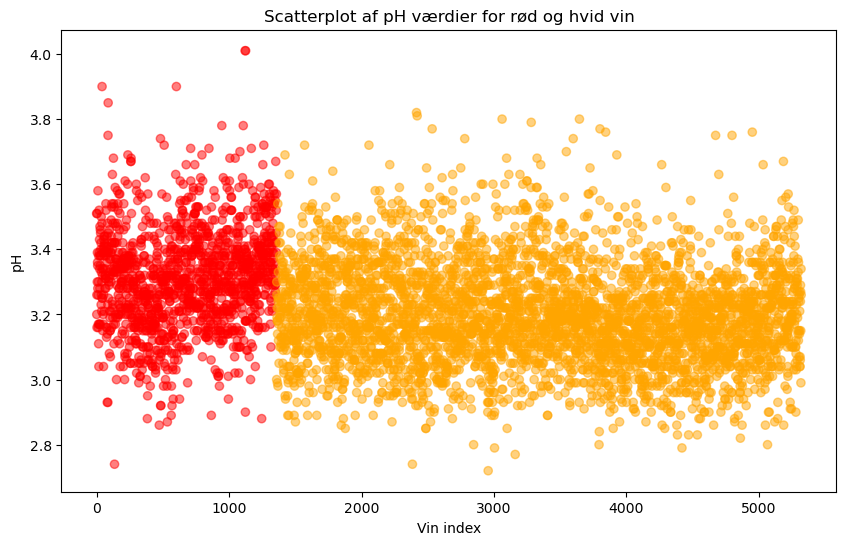

In [21]:
# Scatterplot: x = index (bare rækkefølgen af vin), y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine.index, wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Vin index")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin")
plt.show()


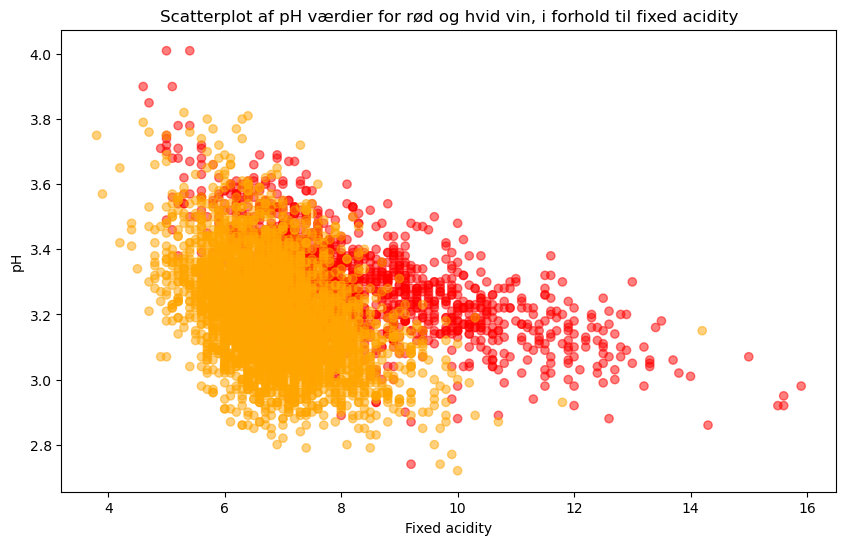

In [22]:
# Scatterplot: x = x = fixed acidity, y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine["fixed acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Fixed acidity")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til fixed acidity")
plt.show()

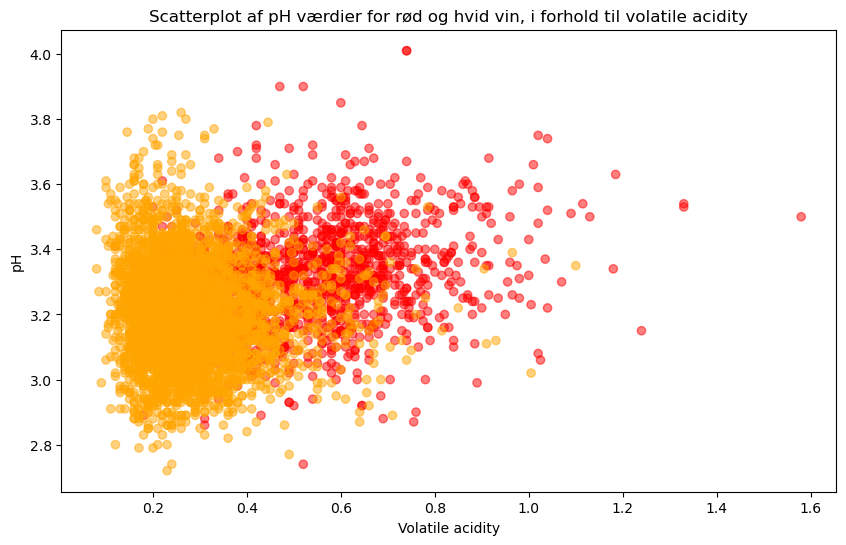

In [23]:
# Scatterplot: x = volatile acidity, y = pH
plt.figure(figsize=(10,6))
plt.scatter(wine["volatile acidity"], wine["pH"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Volatile acidity")
plt.ylabel("pH")
plt.title("Scatterplot af pH værdier for rød og hvid vin, i forhold til volatile acidity")
plt.show()

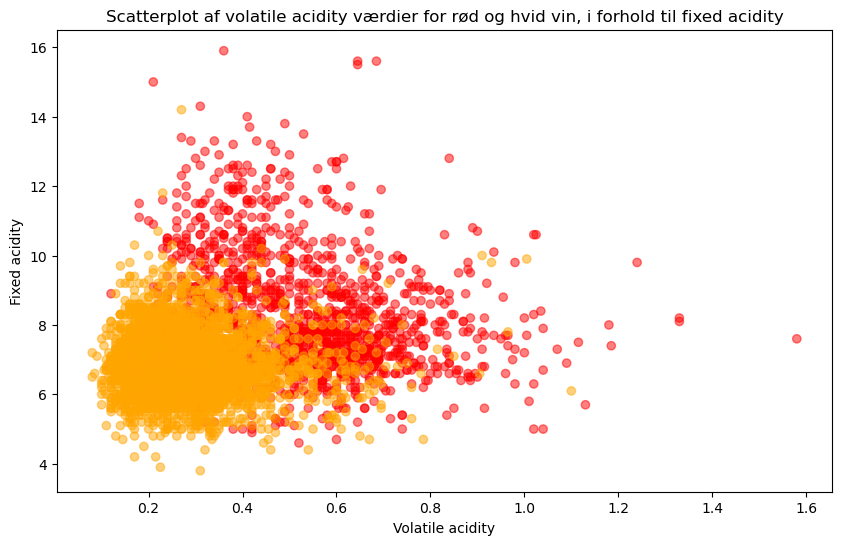

In [24]:
# Scatterplot: x = volatile acidity, y = fixed acidity
plt.figure(figsize=(10,6))
plt.scatter(wine["volatile acidity"], wine["fixed acidity"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Volatile acidity")
plt.ylabel("Fixed acidity")
plt.title("Scatterplot af volatile acidity værdier for rød og hvid vin, i forhold til fixed acidity")
plt.show()

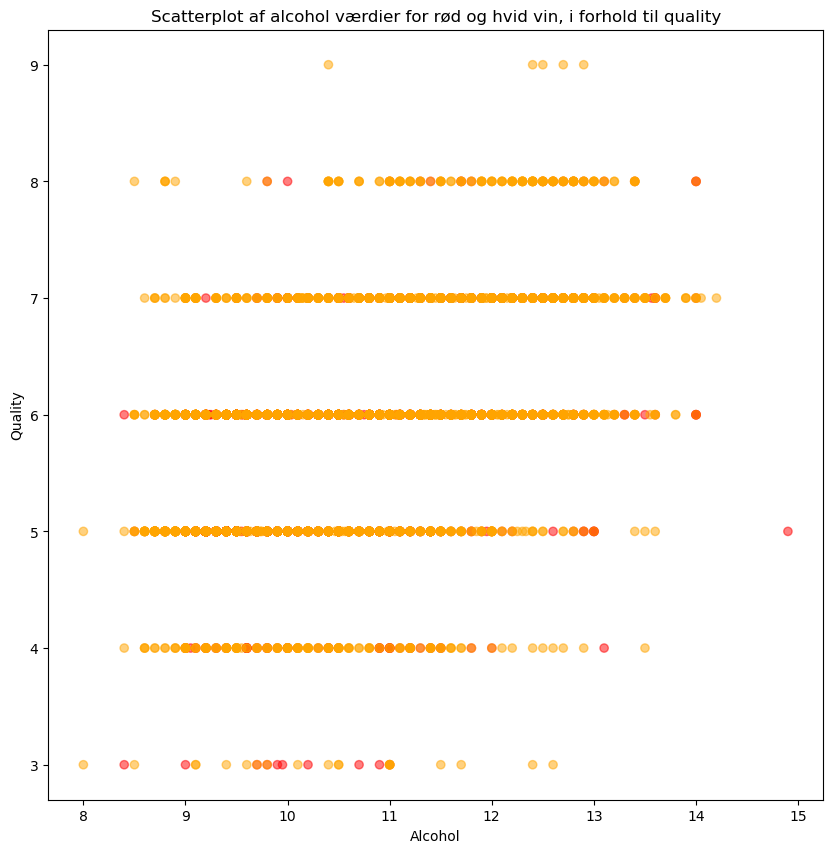

In [25]:
# Scatterplot: x = alcohol, y = quality
plt.figure(figsize=(10,10))
plt.scatter(wine["alcohol"], wine["quality"], alpha=0.5, c=wine["type"].map({"red":"red","white":"orange"}))
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.title("Scatterplot af alcohol værdier for rød og hvid vin, i forhold til quality")
plt.show()

<Figure size 10000x6000 with 0 Axes>

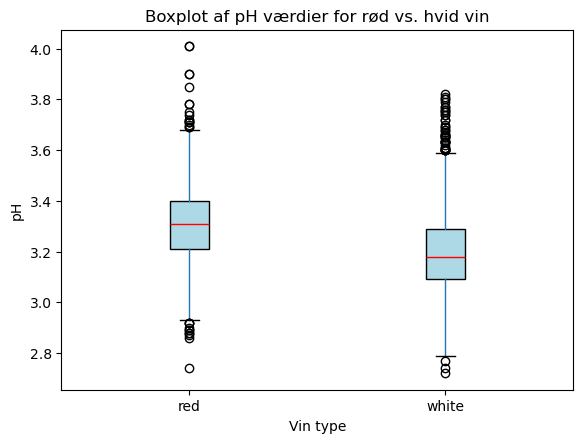

In [30]:
#KOMMER BARE FRA CHAT
plt.figure(figsize=(8,6))
wine.boxplot(column="pH", by="type", grid=False, patch_artist=True,
             boxprops=dict(facecolor="lightblue"),
             medianprops=dict(color="red"))
plt.title("Boxplot af pH værdier for rød vs. hvid vin")
plt.suptitle("")  # fjerner standardtitel
plt.xlabel("Vin type")
plt.ylabel("pH")
plt.show()

In [ ]:
#Checkmark to see if commit and push actually works